# Suffix vs Non-suffix Words

### Packages

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from data_processing import DataGenerator, correct_nasal_vowel_transcripts
from model import GenderLSTM
from model_evaluation import baseline_accuracy, compare_accuracies, statistical_check
from visualization import plot_metrics

### Hyperparameters

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
batch_size = 64
n_epochs = 20
lr = 0.001

hyperparameters = {
    'embed_dim': embedding_dim,
    'hidden_size': hidden_size,
    'batch_size': batch_size,
    'n_epochs': n_epochs,
    'lr': lr
}

### Datasets

In [4]:
nlexique = pd.read_csv('../data/nlexique.csv')
nlexique = nlexique[['lexeme', 'sg', 'gen']].rename(columns={'sg': 'phon'}).dropna().reset_index(drop=True)
tilde = nlexique.iloc[-1]['phon'][-1]
nlexique['phon'] = nlexique['phon'].apply(correct_nasal_vowel_transcripts)
nlexique

,lexeme,phon,gen
0,à-côté,akOte,m
1,à-coup,aku,m
2,à-peu-près,apØpʁɛ,m
3,à-pic,apik,m
4,à-plat,apla,m
...,...,...,...
30999,zurichois,zyʁikwa,m
31000,zydeco,zidəko,f
31001,zygoma,zigOma,m
31002,zygote,zigɔt,m


In [5]:
#check
nlexique[nlexique['phon'].apply(lambda x: tilde in x)]

,lexeme,phon,gen


In [6]:
echantinom = pd.read_csv('../data/Echantinom-full-20210902.csv')
echantinom = echantinom[~echantinom['lemma'].isin(nlexique[nlexique['gen'] == 'b']['lexeme'])][['lemma', 'gen', 'phon', 'suffix']]
echantinom = pd.merge(echantinom, nlexique, left_on='lemma', right_on='lexeme', how='left', suffixes=('_y', ''))\
           .drop(columns=['lexeme', 'phon_y', 'gen_y']).dropna().reset_index(drop=True)
echantinom

,lemma,suffix,phon,gen
0,berlingue,0,bɛʁl3g,m
1,corton,on,kɔʁt2,m
2,dabuche,uche,dabyʃ,f
3,faf,0,faf,m
4,gail,0,gaj,f
...,...,...,...,...
4527,palu,0,paly,m
4528,talc,0,talk,m
4529,sauvetage,age,sOvətaʒ,m
4530,plaid,0,plɛd,m


In [ ]:
# orth_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['lexeme', 'gen']]
# orth_train.to_csv('../data/orth_train.csv', index=None)

# orth_test = echantinom[['lemma', 'gen']]
# orth_test.to_csv('../data/orth_test.csv', index=None)

In [ ]:
# phon_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['phon', 'gen']]
# phon_train.to_csv('../data/phon_train.csv', index=None)

# phon_test = echantinom[['phon', 'gen']]
# phon_test.to_csv('../data/phon_test.csv', index=None)

## Orthographic forms (reversed)

In [6]:
orth_train = pd.read_csv('../data/orth_train.csv')
orth_train

,lexeme,gen
0,à-côté,m
1,à-coup,m
2,à-peu-près,m
3,à-pic,m
4,à-plat,m
...,...,...
24875,zurichois,m
24876,zydeco,f
24877,zygoma,m
24878,zygote,m


In [7]:
orth_test = pd.read_csv('../data/orth_test.csv')
orth_test

,lemma,gen
0,berlingue,m
1,corton,m
2,dabuche,f
3,faf,m
4,gail,f
...,...,...
4527,palu,m
4528,talc,m
4529,sauvetage,m
4530,plaid,m


In [9]:
orth_train_set, orth_valid_set = train_test_split(orth_train, test_size=0.2)

orth_train_generator = DataGenerator(orth_train_set, reverse_nouns=True)
orth_valid_generator = DataGenerator(orth_valid_set, parentgenerator=orth_train_generator, reverse_nouns=True)

orth_model = GenderLSTM(orth_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
orth_train_metrics, orth_valid_metrics = orth_model.train_model(
    orth_train_generator, orth_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_orth_model.pth'
    )

Epoch: 0
[Train] Loss: 0.3552   Accuracy: 85.67%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 61.47%
[Valid] Loss: 0.4343   Accuracy: 77.79%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 67.66%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2500   Accuracy: 89.87%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 60.10%
[Valid] Loss: 0.2790   Accuracy: 87.85%   Beginning of plateau (index): 1   Accuracy at the beginning of plateau: 74.31%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2272   Accuracy: 90.60%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 62.04%
[Valid] Loss: 0.2712   Accuracy: 88.53%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 64.18%
---------------------------------------------

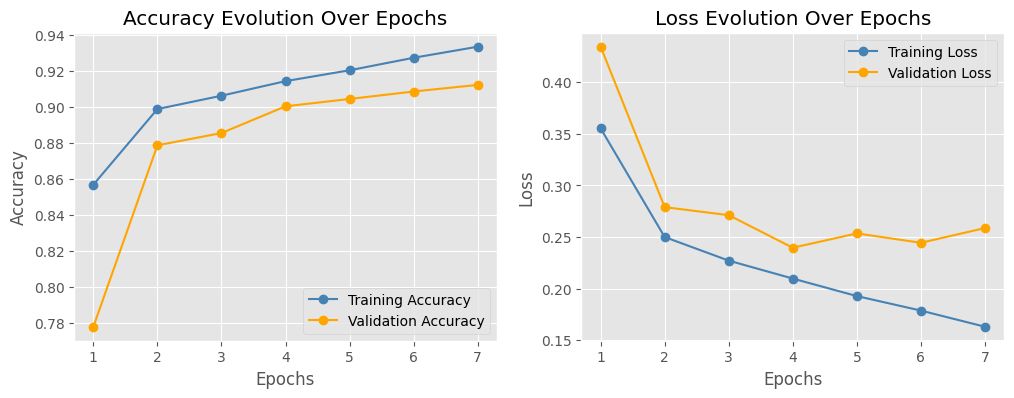

In [10]:
plot_metrics(orth_train_metrics['accuracy'], orth_valid_metrics['accuracy'], orth_train_metrics['loss'], orth_valid_metrics['loss'])

The most frequent label in the dataset is: m


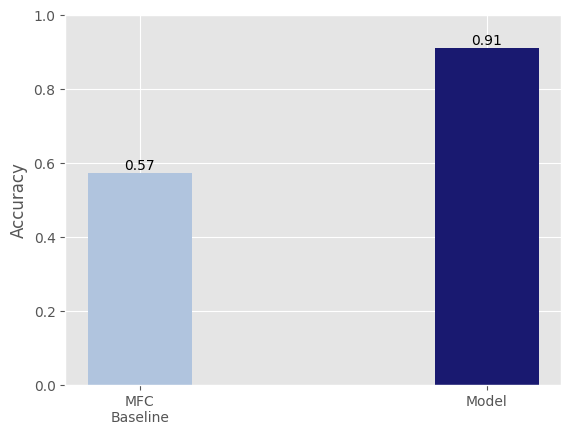

In [42]:
# Comparison with baseline on validation set

baseline_acc = baseline_accuracy(orth_train_generator, orth_valid_generator, verbose=True)

compare_accuracies(baseline_acc, orth_valid_metrics['accuracy'][-1])

In [31]:
orth_test_generator = DataGenerator(orth_test, parentgenerator=orth_train_generator, reverse_nouns=True)
orth_predictions = orth_model.predict(orth_test_generator, batch_size, set='test')

orth_predictions_df = pd.merge(pd.DataFrame(orth_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='lemma', how='left').drop('lemma', axis=1)
orth_predictions_df.insert(1, 'Alt Form', orth_predictions_df.pop('phon'))
orth_predictions_df.to_csv('../results/echantinom_orth_preds_new.csv', index=False)

The most frequent label in the dataset is: m


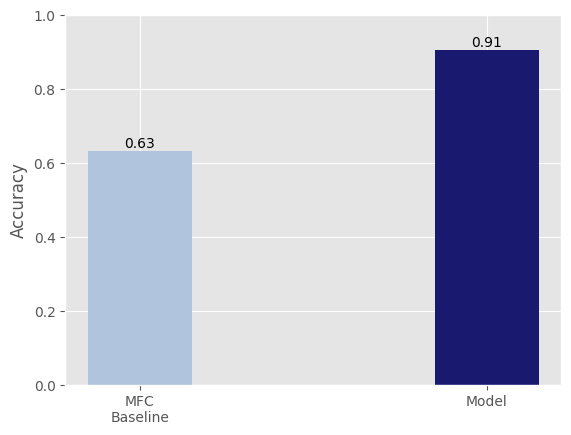

In [45]:
# Comparison with baseline on test set

orth_correct = orth_predictions_df[orth_predictions_df['Predicted Gender'] == orth_predictions_df['True Gender']]
orth_acc = (orth_correct.shape[0] / orth_predictions_df.shape[0])

baseline_acc = baseline_accuracy(orth_train_generator, orth_test_generator, verbose=True)

compare_accuracies(baseline_acc, orth_acc)

In [49]:
statistical_check(orth_train_set, orth_valid_set, orth_test, hyperparameters, outfile='../results/echantinom_orth_preds_x10_new.csv', runs=10, reverse_nouns=True, device=DEVICE)

'Results successfully written to ../results/echantinom_orth_preds_x10_new.csv'

## Phonetic forms (reversed)

In [12]:
phon_train = pd.read_csv('../data/phon_train.csv')
phon_train

,phon,gen
0,akOte,m
1,aku,m
2,apØpʁɛ,m
3,apik,m
4,apla,m
...,...,...
24875,zyʁikwa,m
24876,zidəko,f
24877,zigOma,m
24878,zigɔt,m


In [13]:
phon_test = pd.read_csv('../data/phon_test.csv')
phon_test

,phon,gen
0,bɛʁl3g,m
1,kɔʁt2,m
2,dabyʃ,f
3,faf,m
4,gaj,f
...,...,...
4527,paly,m
4528,talk,m
4529,sOvətaʒ,m
4530,plɛd,m


In [14]:
phon_train_set, phon_valid_set = train_test_split(phon_train, test_size=0.2)

phon_train_generator = DataGenerator(phon_train_set, reverse_nouns=True)
phon_valid_generator = DataGenerator(phon_valid_set, parentgenerator=phon_train_generator, reverse_nouns=True)

phon_model = GenderLSTM(phon_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
phon_train_metrics, phon_valid_metrics = phon_model.train_model(
    phon_train_generator, phon_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_phon_model.pth'
    )

Epoch: 0
[Train] Loss: 0.4196   Accuracy: 79.48%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.25%
[Valid] Loss: 0.4825   Accuracy: 73.50%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.35%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3629   Accuracy: 82.45%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.08%
[Valid] Loss: 0.3794   Accuracy: 82.04%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 54.80%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3314   Accuracy: 84.60%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 57.65%
[Valid] Loss: 0.3539   Accuracy: 83.10%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 55.99%
---------------------------------------------

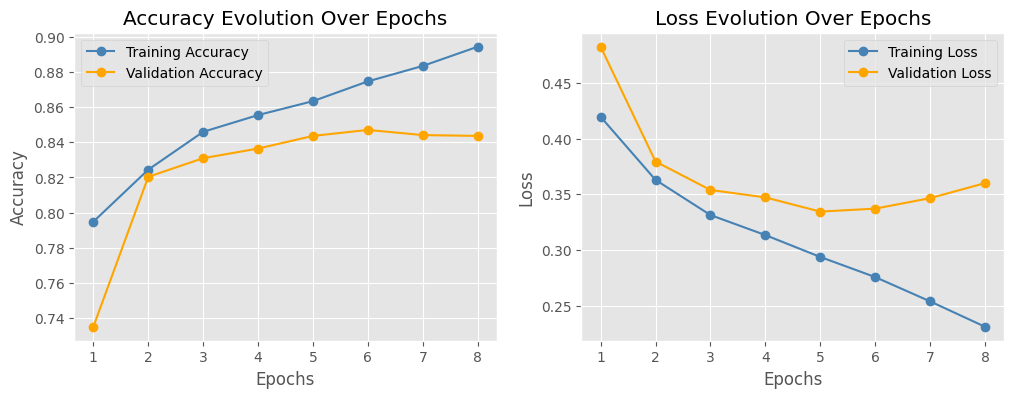

In [15]:
plot_metrics(phon_train_metrics['accuracy'], phon_valid_metrics['accuracy'], phon_train_metrics['loss'], phon_valid_metrics['loss'])

The most frequent label in the dataset is: m


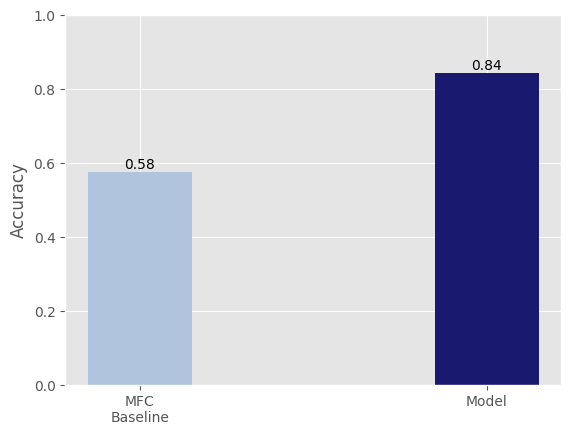

In [46]:
baseline_acc = baseline_accuracy(phon_train_generator, phon_valid_generator, verbose=True)

compare_accuracies(baseline_acc, phon_valid_metrics['accuracy'][-1])

In [39]:
phon_test_generator = DataGenerator(phon_test, parentgenerator=phon_train_generator, reverse_nouns=True)
phon_predictions = phon_model.predict(phon_test_generator, batch_size, set='test')

phon_predictions_df = pd.merge(pd.DataFrame(phon_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='phon', how='left').drop('phon', axis=1)
phon_predictions_df.insert(1, 'Alt Form', phon_predictions_df.pop('lemma'))
phon_predictions_df.to_csv('../results/echantinom_phon_preds_new.csv', index=False)

The most frequent label in the dataset is: m


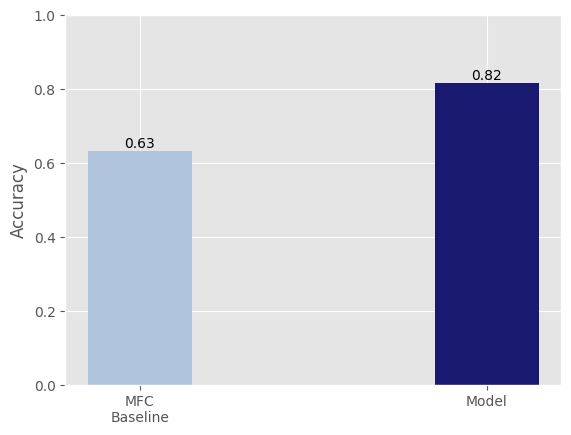

In [47]:
# Comparison with baseline on test set

phon_correct = phon_predictions_df[phon_predictions_df['Predicted Gender'] == phon_predictions_df['True Gender']]
phon_acc = (phon_correct.shape[0] / phon_predictions_df.shape[0])

baseline_acc = baseline_accuracy(phon_train_generator, phon_test_generator, verbose=True)

compare_accuracies(baseline_acc, phon_acc)

In [48]:
statistical_check(phon_train_set, phon_valid_set, phon_test, hyperparameters, outfile='../results/echantinom_phon_preds_x10_new.csv', runs=10, reverse_nouns=True, device=DEVICE)

'Results successfully written to ../results/echantinom_phon_preds_x10_new.csv'

#### Performance Comparison

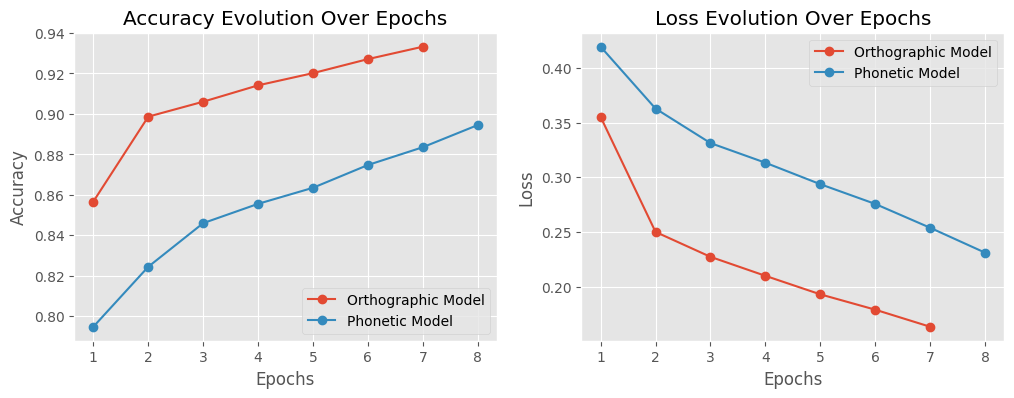

In [25]:
# Accuracy and loss of training sets

train_accuracies = {'Orthographic Model': orth_train_metrics['accuracy'],
                    'Phonemic Model': phon_train_metrics['accuracy']}

train_losses = {'Orthographic Model': orth_train_metrics['loss'],
                'Phonemic Model': phon_train_metrics['loss']}

plot_metrics(train_accuracies, train_losses)

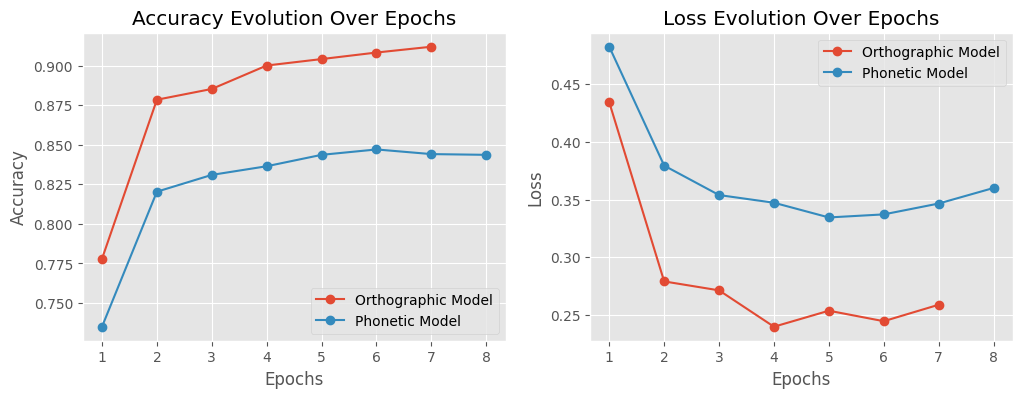

In [26]:
# Accuracy and loss of validation sets

valid_accuracies = {'Orthographic Model': orth_valid_metrics['accuracy'],
                    'Phonetic Model': phon_valid_metrics['accuracy']}

valid_losses = {'Orthographic Model': orth_valid_metrics['loss'],
                'Phonetic Model': phon_valid_metrics['loss']}

plot_metrics(valid_accuracies, valid_losses)

## Orthographic forms (Regular)

In [7]:
orth_train = pd.read_csv('../data/orth_train.csv')
orth_train

,lexeme,gen
0,à-côté,m
1,à-coup,m
2,à-peu-près,m
3,à-pic,m
4,à-plat,m
...,...,...
24875,zurichois,m
24876,zydeco,f
24877,zygoma,m
24878,zygote,m


In [8]:
orth_test = pd.read_csv('../data/orth_test.csv')
orth_test

,lemma,gen
0,berlingue,m
1,corton,m
2,dabuche,f
3,faf,m
4,gail,f
...,...,...
4527,palu,m
4528,talc,m
4529,sauvetage,m
4530,plaid,m


In [9]:
orth_train_set, orth_valid_set = train_test_split(orth_train, test_size=0.2)

orth_train_generator = DataGenerator(orth_train_set, reverse_nouns=False)
orth_valid_generator = DataGenerator(orth_valid_set, parentgenerator=orth_train_generator, reverse_nouns=False)

orth_model = GenderLSTM(orth_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=False)
orth_train_metrics, orth_valid_metrics = orth_model.train_model(
    orth_train_generator, orth_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_orth_model_regular.pth'
    )

Epoch: 0
[Train] Loss: 0.2835   Accuracy: 88.31%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 74.67%
[Valid] Loss: 0.2775   Accuracy: 87.86%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 75.76%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2241   Accuracy: 90.78%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 79.67%
[Valid] Loss: 0.2420   Accuracy: 90.04%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 80.42%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2063   Accuracy: 91.48%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 81.17%
[Valid] Loss: 0.2372   Accuracy: 90.76%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 81.50%
---------------------------------------------

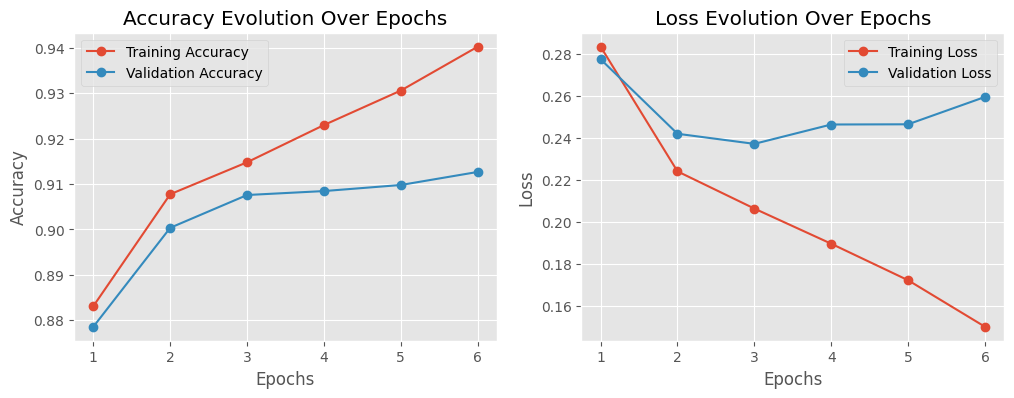

In [12]:
accuracies = {'Training Accuracy': orth_train_metrics['accuracy'],
              'Validation Accuracy': orth_valid_metrics['accuracy']}

losses = {'Training Loss': orth_train_metrics['loss'],
          'Validation Loss': orth_valid_metrics['loss']}

plot_metrics(accuracies, losses)

The most frequent label in the dataset is: m


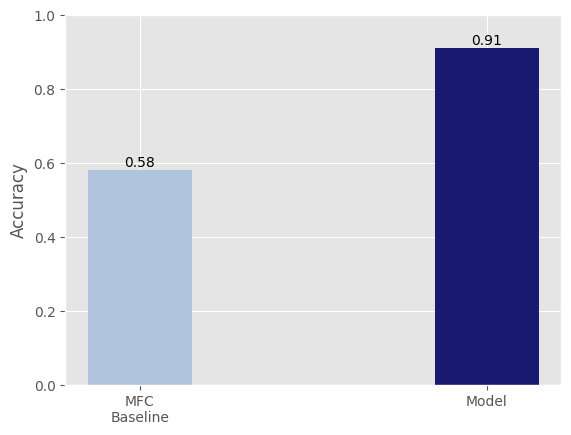

In [13]:
# Comparison with baseline on validation set

baseline_acc = baseline_accuracy(orth_train_generator, orth_valid_generator, verbose=True)

compare_accuracies(baseline_acc, orth_valid_metrics['accuracy'][-1])

In [14]:
orth_test_generator = DataGenerator(orth_test, parentgenerator=orth_train_generator, reverse_nouns=False)
orth_predictions = orth_model.predict(orth_test_generator, batch_size, set='test')

orth_predictions_df = pd.merge(pd.DataFrame(orth_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='lemma', how='left').drop('lemma', axis=1)
orth_predictions_df.insert(1, 'Alt Form', orth_predictions_df.pop('phon'))
orth_predictions_df.to_csv('../results/echantinom_orth_preds_regular.csv', index=False)

The most frequent label in the dataset is: m


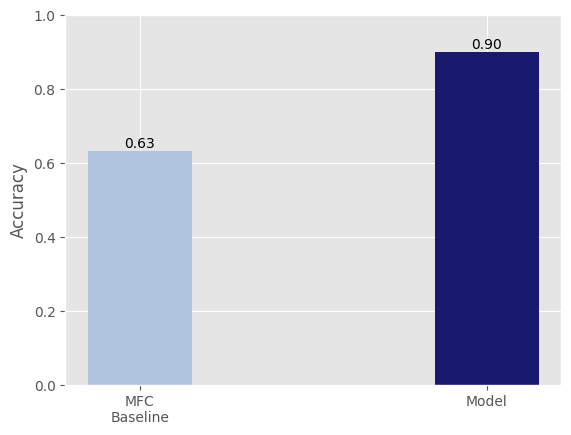

In [15]:
# Comparison with baseline on test set

orth_correct = orth_predictions_df[orth_predictions_df['Predicted Gender'] == orth_predictions_df['True Gender']]
orth_acc = (orth_correct.shape[0] / orth_predictions_df.shape[0])

baseline_acc = baseline_accuracy(orth_train_generator, orth_test_generator, verbose=True)

compare_accuracies(baseline_acc, orth_acc)

In [16]:
statistical_check(orth_train_set, orth_valid_set, orth_test, hyperparameters, outfile='../results/echantinom_orth_preds_x10_regular.csv', runs=10, reverse_nouns=False, device=DEVICE)

'Results successfully written to ../results/echantinom_orth_preds_x10_regular.csv'

## Phonetic forms (regular)

In [17]:
phon_train = pd.read_csv('../data/phon_train.csv')
phon_train

,phon,gen
0,akOte,m
1,aku,m
2,apØpʁɛ,m
3,apik,m
4,apla,m
...,...,...
24875,zyʁikwa,m
24876,zidəko,f
24877,zigOma,m
24878,zigɔt,m


In [18]:
phon_test = pd.read_csv('../data/phon_test.csv')
phon_test

,phon,gen
0,bɛʁl3g,m
1,kɔʁt2,m
2,dabyʃ,f
3,faf,m
4,gaj,f
...,...,...
4527,paly,m
4528,talk,m
4529,sOvətaʒ,m
4530,plɛd,m


In [19]:
phon_train_set, phon_valid_set = train_test_split(phon_train, test_size=0.2)

phon_train_generator = DataGenerator(phon_train_set, reverse_nouns=False)
phon_valid_generator = DataGenerator(phon_valid_set, parentgenerator=phon_train_generator, reverse_nouns=False)

phon_model = GenderLSTM(phon_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=False)
phon_train_metrics, phon_valid_metrics = phon_model.train_model(
    phon_train_generator, phon_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_phon_model_regular.pth'
    )

Epoch: 0
[Train] Loss: 0.3735   Accuracy: 82.47%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 70.32%
[Valid] Loss: 0.4171   Accuracy: 80.21%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 75.86%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3288   Accuracy: 85.03%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 71.80%
[Valid] Loss: 0.3932   Accuracy: 81.88%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 76.16%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3063   Accuracy: 86.15%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 72.20%
[Valid] Loss: 0.3821   Accuracy: 82.74%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 74.73%
---------------------------------------------

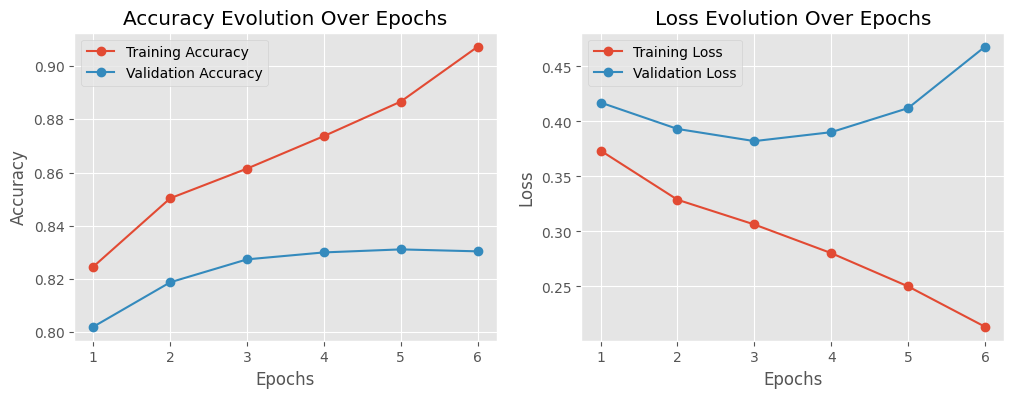

In [20]:
accuracies = {'Training Accuracy': phon_train_metrics['accuracy'],
              'Validation Accuracy': phon_valid_metrics['accuracy']}

losses = {'Training Loss': phon_train_metrics['loss'],
          'Validation Loss': phon_valid_metrics['loss']}

plot_metrics(accuracies, losses)

The most frequent label in the dataset is: m


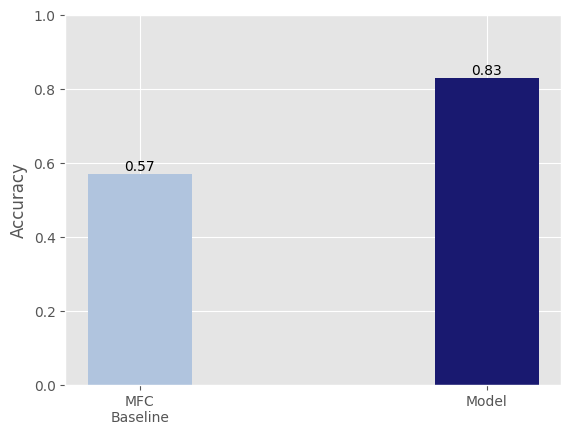

In [21]:
baseline_acc = baseline_accuracy(phon_train_generator, phon_valid_generator, verbose=True)

compare_accuracies(baseline_acc, phon_valid_metrics['accuracy'][-1])

In [22]:
phon_test_generator = DataGenerator(phon_test, parentgenerator=phon_train_generator, reverse_nouns=False)
phon_predictions = phon_model.predict(phon_test_generator, batch_size, set='test')

phon_predictions_df = pd.merge(pd.DataFrame(phon_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='phon', how='left').drop('phon', axis=1)
phon_predictions_df.insert(1, 'Alt Form', phon_predictions_df.pop('lemma'))
phon_predictions_df.to_csv('../results/echantinom_phon_preds_regular.csv', index=False)

The most frequent label in the dataset is: m


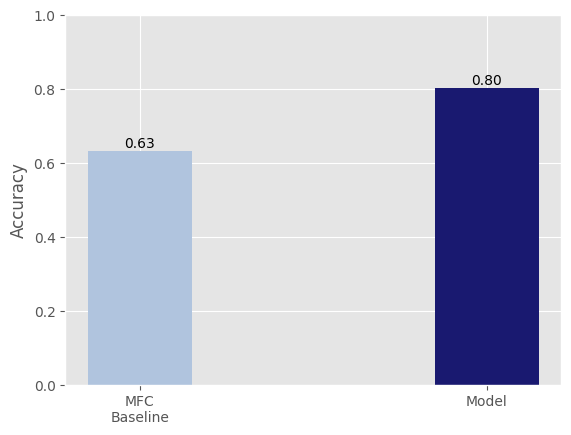

In [23]:
# Comparison with baseline on test set

phon_correct = phon_predictions_df[phon_predictions_df['Predicted Gender'] == phon_predictions_df['True Gender']]
phon_acc = (phon_correct.shape[0] / phon_predictions_df.shape[0])

baseline_acc = baseline_accuracy(phon_train_generator, phon_test_generator, verbose=True)

compare_accuracies(baseline_acc, phon_acc)

In [24]:
statistical_check(phon_train_set, phon_valid_set, phon_test, hyperparameters, outfile='../results/echantinom_phon_preds_x10_regular.csv', runs=10, reverse_nouns=False, device=DEVICE)

'Results successfully written to ../results/echantinom_phon_preds_x10_regular.csv'

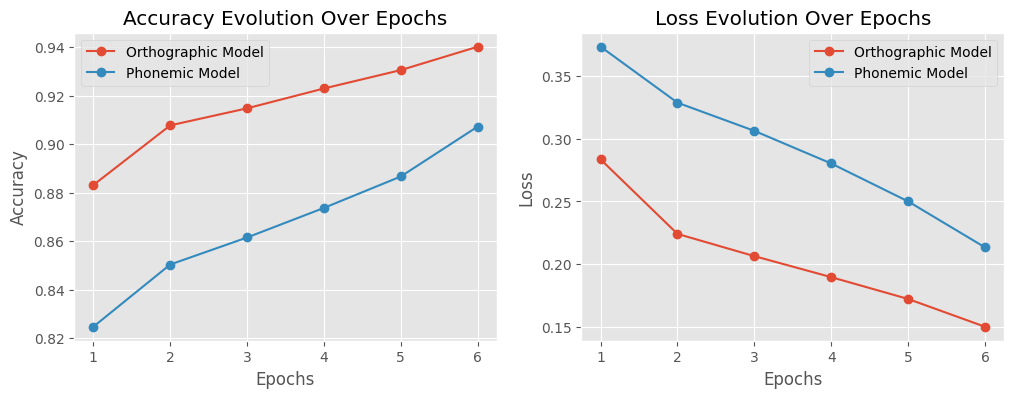

In [25]:
# Accuracy and loss of training sets

train_accuracies = {'Orthographic Model': orth_train_metrics['accuracy'],
                    'Phonemic Model': phon_train_metrics['accuracy']}

train_losses = {'Orthographic Model': orth_train_metrics['loss'],
                'Phonemic Model': phon_train_metrics['loss']}

plot_metrics(train_accuracies, train_losses)

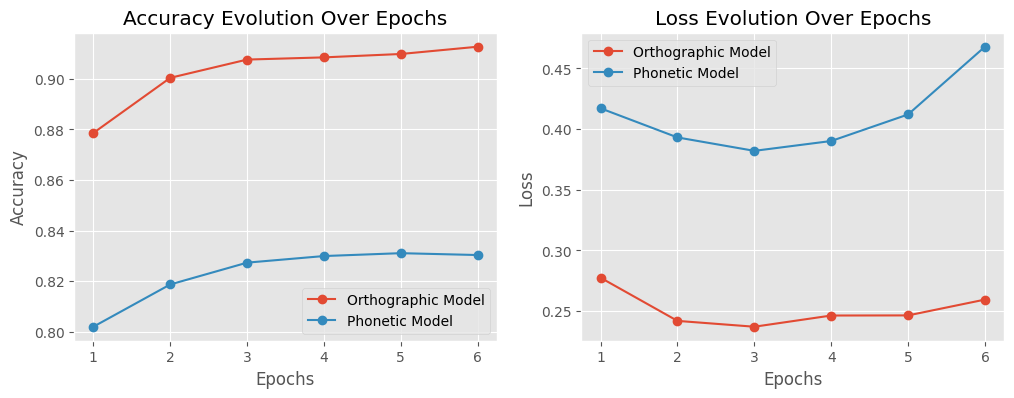

In [26]:
# Accuracy and loss of validation sets

valid_accuracies = {'Orthographic Model': orth_valid_metrics['accuracy'],
                    'Phonetic Model': phon_valid_metrics['accuracy']}

valid_losses = {'Orthographic Model': orth_valid_metrics['loss'],
                'Phonetic Model': phon_valid_metrics['loss']}

plot_metrics(valid_accuracies, valid_losses)